In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('max_rows', 300)
pd.set_option('max_columns', 300)

import os
import glob
import statsmodels.api as sm

# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

# 関数準備

In [2]:
def calc_wap(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1'])/(df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2'])/(df['bid_size2'] + df['ask_size2'])
    return wap

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def trend_return(df):
    seasonal_decompose_res = sm.tsa.seasonal_decompose(df, freq=1)
    return seasonal_decompose_res.trend

def calc_bollinger_band(df):
    window=10
    wap_bol_upper = df["wap"].rolling(window=window).mean() + (df["wap"].rolling(window=window).std() * 2)
    wap_bol_lower = df["wap"].rolling(window=window).mean() - (df["wap"].rolling(window=window).std() * 2)
    wap_bol_balance = wap_bol_upper - wap_bol_lower
    return wap_bol_balance

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

def count_unique(series):
    return len(np.unique(series))


# Book_Dataの特徴量抽出関数

In [3]:
def preprocessor_book(file_path):
    df = pd.read_parquet(file_path)
    #calculate return etc
    df['wap'] = calc_wap(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    df['wap4'] = calc_wap4(df)
    
    df['log_return'] = df.groupby('time_id')['wap'].apply(log_return)
    df['log_return2'] = df.groupby('time_id')['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)
    
    df['bollinger_band_balance'] = calc_bollinger_band(df)
    df['wap_balance'] = abs(df['wap'] - df['wap2'])
    
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    #dict for aggregate
    create_feature_dict = {
        'wap': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'wap3': [np.sum, np.mean, np.std],
        'wap4': [np.sum, np.mean, np.std],
        'log_return':[realized_volatility,np.sum, np.mean, np.std],
        'log_return2':[realized_volatility,np.sum, np.mean, np.std],
        'log_return3':[realized_volatility,np.sum, np.mean, np.std],
        'log_return4':[realized_volatility,np.sum, np.mean, np.std],
        'bollinger_band_balance':[np.sum, np.mean, np.std],
        'wap_balance':[np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'price_spread2':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        "bid_ask_spread":[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
            }

    #####groupby / all seconds
    df_feature = pd.DataFrame(df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    
    df_feature.columns = ['_'.join(col) for col in df_feature.columns] #time_id is changed to time_id_
        
    ######groupby / last XX seconds
    last_seconds = [100,200,300,400,500]
    
    for second in last_seconds:
        second = 600 - second 
    
        df_feature_sec = pd.DataFrame(df.query(f'seconds_in_bucket >= {second}').groupby(['time_id']).agg(create_feature_dict)).reset_index()
        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns] #time_id is changed to time_id_
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    #create row_id
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['time_id_'],axis=1)
    
    return df_feature

# Trade_Dataの特徴量抽出

In [4]:
def preprocessor_trade(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    
    aggregate_dictionary = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    
    df_feature = df.groupby('time_id').agg(aggregate_dictionary)
    
    df_feature = df_feature.reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]

    
    ######groupby / last XX seconds
    last_seconds = [100,200,300,400,500]
    
    for second in last_seconds:
        second = 600 - second
    
        df_feature_sec = df.query(f'seconds_in_bucket >= {second}').groupby('time_id').agg(aggregate_dictionary)
        df_feature_sec = df_feature_sec.reset_index()
        
        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        
        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['trade_time_id_'],axis=1)
    
    return df_feature

# BookとTradeのデータをJoinする

In [5]:
def preprocessor(list_stock_ids, is_train = True):
    from joblib import Parallel, delayed # parallel computing to save time
    df = pd.DataFrame()
    
    def for_joblib(stock_id):
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
            
        df_tmp = pd.merge(preprocessor_book(file_path_book),preprocessor_trade(file_path_trade),on='row_id',how='left')
     
        return pd.concat([df,df_tmp])
    
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(for_joblib)(stock_id) for stock_id in list_stock_ids
        )

    df =  pd.concat(df,ignore_index = True)
    return df

# データ
## 学習データ準備

In [6]:
train = pd.read_csv(data_dir + 'train.csv')
train_ids = train.stock_id.unique()

In [7]:
%%time
df_train = preprocessor(list_stock_ids= train_ids, is_train = True)
df_train_temp = df_train

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 42.5min finished


CPU times: user 14.6 s, sys: 2.25 s, total: 16.9 s
Wall time: 42min 34s


In [8]:
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]
df_train = train.merge(df_train_temp, on = ['row_id'], how = 'left')
df_train.head()

,row_id,target,wap_sum,wap_mean,wap_std,wap2_sum,wap2_mean,wap2_std,wap3_sum,wap3_mean,wap3_std,wap4_sum,wap4_mean,wap4_std,log_return_realized_volatility,log_return_sum,log_return_mean,log_return_std,log_return2_realized_volatility,log_return2_sum,log_return2_mean,log_return2_std,log_return3_realized_volatility,log_return3_sum,log_return3_mean,log_return3_std,log_return4_realized_volatility,log_return4_sum,log_return4_mean,log_return4_std,bollinger_band_balance_sum,bollinger_band_balance_mean,bollinger_band_balance_std,wap_balance_sum,wap_balance_mean,wap_balance_std,price_spread_sum,price_spread_mean,price_spread_std,price_spread2_sum,price_spread2_mean,price_spread2_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,bid_ask_spread_sum,bid_ask_spread_mean,bid_ask_spread_std,volume_imbalance_sum,volume_imbalance_mean,volume_imbalance_std,total_volume_sum,total_volume_mean,total_volume_std,wap_sum_500,wap_mean_500,wap_std_500,wap2_sum_500,wap2_mean_500,wap2_std_500,wap3_sum_500,wap3_mean_500,wap3_std_500,wap4_sum_500,wap4_mean_500,wap4_std_500,log_return_realized_volatility_500,log_return_sum_500,log_return_mean_500,log_return_std_500,log_return2_realized_volatility_500,log_return2_sum_500,log_return2_mean_500,log_return2_std_500,log_return3_realized_volatility_500,log_return3_sum_500,log_return3_mean_500,log_return3_std_500,log_return4_realized_volatility_500,log_return4_sum_500,log_return4_mean_500,log_return4_std_500,bollinger_band_balance_sum_500,bollinger_band_balance_mean_500,bollinger_band_balance_std_500,wap_balance_sum_500,wap_balance_mean_500,wap_balance_std_500,price_spread_sum_500,price_spread_mean_500,price_spread_std_500,price_spread2_sum_500,price_spread2_mean_500,price_spread2_std_500,bid_spread_sum_500,bid_spread_mean_500,bid_spread_std_500,ask_spread_sum_500,ask_spread_mean_500,ask_spread_std_500,bid_ask_spread_sum_500,bid_ask_spread_mean_500,bid_ask_spread_std_500,volume_imbalance_sum_500,volume_imbalance_mean_500,volume_imbalance_std_500,total_volume_sum_500,total_volume_mean_500,total_volume_std_500,wap_sum_400,wap_mean_400,wap_std_400,wap2_sum_400,wap2_mean_400,wap2_std_400,wap3_sum_400,wap3_mean_400,wap3_std_400,wap4_sum_400,wap4_mean_400,wap4_std_400,log_return_realized_volatility_400,log_return_sum_400,log_return_mean_400,log_return_std_400,log_return2_realized_volatility_400,log_return2_sum_400,log_return2_mean_400,log_return2_std_400,log_return3_realized_volatility_400,log_return3_sum_400,log_return3_mean_400,log_return3_std_400,log_return4_realized_volatility_400,log_return4_sum_400,log_return4_mean_400,log_return4_std_400,bollinger_band_balance_sum_400,bollinger_band_balance_mean_400,bollinger_band_balance_std_400,wap_balance_sum_400,wap_balance_mean_400,wap_balance_std_400,price_spread_sum_400,price_spread_mean_400,price_spread_std_400,price_spread2_sum_400,...,price_spread2_std_300,bid_spread_sum_300,bid_spread_mean_300,bid_spread_std_300,ask_spread_sum_300,ask_spread_mean_300,ask_spread_std_300,bid_ask_spread_sum_300,bid_ask_spread_mean_300,bid_ask_spread_std_300,volume_imbalance_sum_300,volume_imbalance_mean_300,volume_imbalance_std_300,total_volume_sum_300,total_volume_mean_300,total_volume_std_300,wap_sum_200,wap_mean_200,wap_std_200,wap2_sum_200,wap2_mean_200,wap2_std_200,wap3_sum_200,wap3_mean_200,wap3_std_200,wap4_sum_200,wap4_mean_200,wap4_std_200,log_return_realized_volatility_200,log_return_sum_200,log_return_mean_200,log_return_std_200,log_return2_realized_volatility_200,log_return2_sum_200,log_return2_mean_200,log_return2_std_200,log_return3_realized_volatility_200,log_return3_sum_200,log_return3_mean_200,log_return3_std_200,log_return4_realized_volatility_200,log_return4_sum_200,log_return4_mean_200,log_return4_std_200,bollinger_band_balance_sum_200,bollinger_band_balance_mean_200,bollinger_band_balance_std_200,wap_balance_sum_200,wap_balance_mean_200,wap_balance_std_200,price_spread_sum_200,price_spread_mean_200,price_spread_std_200,price

## テストデータ準備

In [9]:
test = pd.read_csv(data_dir + 'test.csv')
test_ids = test.stock_id.unique()

In [10]:
test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [11]:
%%time
df_test = preprocessor(list_stock_ids= test_ids, is_train = False)
df_test_temp = df_test

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 40.8 ms, sys: 6.46 ms, total: 47.3 ms
Wall time: 666 ms


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


In [12]:
df_test = test.merge(df_test, on = ['row_id'], how = 'left')
df_test.head()

,stock_id,time_id,row_id,wap_sum,wap_mean,wap_std,wap2_sum,wap2_mean,wap2_std,wap3_sum,wap3_mean,wap3_std,wap4_sum,wap4_mean,wap4_std,log_return_realized_volatility,log_return_sum,log_return_mean,log_return_std,log_return2_realized_volatility,log_return2_sum,log_return2_mean,log_return2_std,log_return3_realized_volatility,log_return3_sum,log_return3_mean,log_return3_std,log_return4_realized_volatility,log_return4_sum,log_return4_mean,log_return4_std,bollinger_band_balance_sum,bollinger_band_balance_mean,bollinger_band_balance_std,wap_balance_sum,wap_balance_mean,wap_balance_std,price_spread_sum,price_spread_mean,price_spread_std,price_spread2_sum,price_spread2_mean,price_spread2_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,bid_ask_spread_sum,bid_ask_spread_mean,bid_ask_spread_std,volume_imbalance_sum,volume_imbalance_mean,volume_imbalance_std,total_volume_sum,total_volume_mean,total_volume_std,wap_sum_500,wap_mean_500,wap_std_500,wap2_sum_500,wap2_mean_500,wap2_std_500,wap3_sum_500,wap3_mean_500,wap3_std_500,wap4_sum_500,wap4_mean_500,wap4_std_500,log_return_realized_volatility_500,log_return_sum_500,log_return_mean_500,log_return_std_500,log_return2_realized_volatility_500,log_return2_sum_500,log_return2_mean_500,log_return2_std_500,log_return3_realized_volatility_500,log_return3_sum_500,log_return3_mean_500,log_return3_std_500,log_return4_realized_volatility_500,log_return4_sum_500,log_return4_mean_500,log_return4_std_500,bollinger_band_balance_sum_500,bollinger_band_balance_mean_500,bollinger_band_balance_std_500,wap_balance_sum_500,wap_balance_mean_500,wap_balance_std_500,price_spread_sum_500,price_spread_mean_500,price_spread_std_500,price_spread2_sum_500,price_spread2_mean_500,price_spread2_std_500,bid_spread_sum_500,bid_spread_mean_500,bid_spread_std_500,ask_spread_sum_500,ask_spread_mean_500,ask_spread_std_500,bid_ask_spread_sum_500,bid_ask_spread_mean_500,bid_ask_spread_std_500,volume_imbalance_sum_500,volume_imbalance_mean_500,volume_imbalance_std_500,total_volume_sum_500,total_volume_mean_500,total_volume_std_500,wap_sum_400,wap_mean_400,wap_std_400,wap2_sum_400,wap2_mean_400,wap2_std_400,wap3_sum_400,wap3_mean_400,wap3_std_400,wap4_sum_400,wap4_mean_400,wap4_std_400,log_return_realized_volatility_400,log_return_sum_400,log_return_mean_400,log_return_std_400,log_return2_realized_volatility_400,log_return2_sum_400,log_return2_mean_400,log_return2_std_400,log_return3_realized_volatility_400,log_return3_sum_400,log_return3_mean_400,log_return3_std_400,log_return4_realized_volatility_400,log_return4_sum_400,log_return4_mean_400,log_return4_std_400,bollinger_band_balance_sum_400,bollinger_band_balance_mean_400,bollinger_band_balance_std_400,wap_balance_sum_400,wap_balance_mean_400,wap_balance_std_400,price_spread_sum_400,price_spread_mean_400,price_spread_std_400,...,price_spread2_std_300,bid_spread_sum_300,bid_spread_mean_300,bid_spread_std_300,ask_spread_sum_300,ask_spread_mean_300,ask_spread_std_300,bid_ask_spread_sum_300,bid_ask_spread_mean_300,bid_ask_spread_std_300,volume_imbalance_sum_300,volume_imbalance_mean_300,volume_imbalance_std_300,total_volume_sum_300,total_volume_mean_300,total_volume_std_300,wap_sum_200,wap_mean_200,wap_std_200,wap2_sum_200,wap2_mean_200,wap2_std_200,wap3_sum_200,wap3_mean_200,wap3_std_200,wap4_sum_200,wap4_mean_200,wap4_std_200,log_return_realized_volatility_200,log_return_sum_200,log_return_mean_200,log_return_std_200,log_return2_realized_volatility_200,log_return2_sum_200,log_return2_mean_200,log_return2_std_200,log_return3_realized_volatility_200,log_return3_sum_200,log_return3_mean_200,log_return3_std_200,log_return4_realized_volatility_200,log_return4_sum_200,log_return4_mean_200,log_return4_std_200,bollinger_band_balance_sum_200,bollinger_band_balance_mean_200,bollinger_band_balance_std_200,wap_balance_sum_200,wap_balance_mean_200,wap_balance_std_200,price_spread_sum_200,price_spread_mean_200,price_spread_std_200,price_spread2_sum

In [13]:
from sklearn.model_selection import KFold
#stock_id target encoding
df_train['stock_id'] = df_train['row_id'].apply(lambda x:x.split('-')[0])
df_test['stock_id'] = df_test['row_id'].apply(lambda x:x.split('-')[0])

stock_id_target_mean = df_train.groupby('stock_id')['target'].mean() 
df_test['stock_id_target_enc'] = df_test['stock_id'].map(stock_id_target_mean) # test_set

#training
tmp = np.repeat(np.nan, df_train.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 19911109)
for idx_1, idx_2 in kf.split(df_train):
    target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()

    tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)
df_train['stock_id_target_enc'] = tmp

# Model Building

In [14]:
df_train.head()

,row_id,target,wap_sum,wap_mean,wap_std,wap2_sum,wap2_mean,wap2_std,wap3_sum,wap3_mean,wap3_std,wap4_sum,wap4_mean,wap4_std,log_return_realized_volatility,log_return_sum,log_return_mean,log_return_std,log_return2_realized_volatility,log_return2_sum,log_return2_mean,log_return2_std,log_return3_realized_volatility,log_return3_sum,log_return3_mean,log_return3_std,log_return4_realized_volatility,log_return4_sum,log_return4_mean,log_return4_std,bollinger_band_balance_sum,bollinger_band_balance_mean,bollinger_band_balance_std,wap_balance_sum,wap_balance_mean,wap_balance_std,price_spread_sum,price_spread_mean,price_spread_std,price_spread2_sum,price_spread2_mean,price_spread2_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,bid_ask_spread_sum,bid_ask_spread_mean,bid_ask_spread_std,volume_imbalance_sum,volume_imbalance_mean,volume_imbalance_std,total_volume_sum,total_volume_mean,total_volume_std,wap_sum_500,wap_mean_500,wap_std_500,wap2_sum_500,wap2_mean_500,wap2_std_500,wap3_sum_500,wap3_mean_500,wap3_std_500,wap4_sum_500,wap4_mean_500,wap4_std_500,log_return_realized_volatility_500,log_return_sum_500,log_return_mean_500,log_return_std_500,log_return2_realized_volatility_500,log_return2_sum_500,log_return2_mean_500,log_return2_std_500,log_return3_realized_volatility_500,log_return3_sum_500,log_return3_mean_500,log_return3_std_500,log_return4_realized_volatility_500,log_return4_sum_500,log_return4_mean_500,log_return4_std_500,bollinger_band_balance_sum_500,bollinger_band_balance_mean_500,bollinger_band_balance_std_500,wap_balance_sum_500,wap_balance_mean_500,wap_balance_std_500,price_spread_sum_500,price_spread_mean_500,price_spread_std_500,price_spread2_sum_500,price_spread2_mean_500,price_spread2_std_500,bid_spread_sum_500,bid_spread_mean_500,bid_spread_std_500,ask_spread_sum_500,ask_spread_mean_500,ask_spread_std_500,bid_ask_spread_sum_500,bid_ask_spread_mean_500,bid_ask_spread_std_500,volume_imbalance_sum_500,volume_imbalance_mean_500,volume_imbalance_std_500,total_volume_sum_500,total_volume_mean_500,total_volume_std_500,wap_sum_400,wap_mean_400,wap_std_400,wap2_sum_400,wap2_mean_400,wap2_std_400,wap3_sum_400,wap3_mean_400,wap3_std_400,wap4_sum_400,wap4_mean_400,wap4_std_400,log_return_realized_volatility_400,log_return_sum_400,log_return_mean_400,log_return_std_400,log_return2_realized_volatility_400,log_return2_sum_400,log_return2_mean_400,log_return2_std_400,log_return3_realized_volatility_400,log_return3_sum_400,log_return3_mean_400,log_return3_std_400,log_return4_realized_volatility_400,log_return4_sum_400,log_return4_mean_400,log_return4_std_400,bollinger_band_balance_sum_400,bollinger_band_balance_mean_400,bollinger_band_balance_std_400,wap_balance_sum_400,wap_balance_mean_400,wap_balance_std_400,price_spread_sum_400,price_spread_mean_400,price_spread_std_400,price_spread2_sum_400,...,bid_spread_mean_300,bid_spread_std_300,ask_spread_sum_300,ask_spread_mean_300,ask_spread_std_300,bid_ask_spread_sum_300,bid_ask_spread_mean_300,bid_ask_spread_std_300,volume_imbalance_sum_300,volume_imbalance_mean_300,volume_imbalance_std_300,total_volume_sum_300,total_volume_mean_300,total_volume_std_300,wap_sum_200,wap_mean_200,wap_std_200,wap2_sum_200,wap2_mean_200,wap2_std_200,wap3_sum_200,wap3_mean_200,wap3_std_200,wap4_sum_200,wap4_mean_200,wap4_std_200,log_return_realized_volatility_200,log_return_sum_200,log_return_mean_200,log_return_std_200,log_return2_realized_volatility_200,log_return2_sum_200,log_return2_mean_200,log_return2_std_200,log_return3_realized_volatility_200,log_return3_sum_200,log_return3_mean_200,log_return3_std_200,log_return4_realized_volatility_200,log_return4_sum_200,log_return4_mean_200,log_return4_std_200,bollinger_band_balance_sum_200,bollinger_band_balance_mean_200,bollinger_band_balance_std_200,wap_balance_sum_200,wap_balance_mean_200,wap_balance_std_200,price_spread_sum_200,price_spread_mean_200,price_spread_std_200,price_spread2_sum_200,price_spread2_mean_200,p

In [15]:
df_test.head()

,stock_id,time_id,row_id,wap_sum,wap_mean,wap_std,wap2_sum,wap2_mean,wap2_std,wap3_sum,wap3_mean,wap3_std,wap4_sum,wap4_mean,wap4_std,log_return_realized_volatility,log_return_sum,log_return_mean,log_return_std,log_return2_realized_volatility,log_return2_sum,log_return2_mean,log_return2_std,log_return3_realized_volatility,log_return3_sum,log_return3_mean,log_return3_std,log_return4_realized_volatility,log_return4_sum,log_return4_mean,log_return4_std,bollinger_band_balance_sum,bollinger_band_balance_mean,bollinger_band_balance_std,wap_balance_sum,wap_balance_mean,wap_balance_std,price_spread_sum,price_spread_mean,price_spread_std,price_spread2_sum,price_spread2_mean,price_spread2_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,bid_ask_spread_sum,bid_ask_spread_mean,bid_ask_spread_std,volume_imbalance_sum,volume_imbalance_mean,volume_imbalance_std,total_volume_sum,total_volume_mean,total_volume_std,wap_sum_500,wap_mean_500,wap_std_500,wap2_sum_500,wap2_mean_500,wap2_std_500,wap3_sum_500,wap3_mean_500,wap3_std_500,wap4_sum_500,wap4_mean_500,wap4_std_500,log_return_realized_volatility_500,log_return_sum_500,log_return_mean_500,log_return_std_500,log_return2_realized_volatility_500,log_return2_sum_500,log_return2_mean_500,log_return2_std_500,log_return3_realized_volatility_500,log_return3_sum_500,log_return3_mean_500,log_return3_std_500,log_return4_realized_volatility_500,log_return4_sum_500,log_return4_mean_500,log_return4_std_500,bollinger_band_balance_sum_500,bollinger_band_balance_mean_500,bollinger_band_balance_std_500,wap_balance_sum_500,wap_balance_mean_500,wap_balance_std_500,price_spread_sum_500,price_spread_mean_500,price_spread_std_500,price_spread2_sum_500,price_spread2_mean_500,price_spread2_std_500,bid_spread_sum_500,bid_spread_mean_500,bid_spread_std_500,ask_spread_sum_500,ask_spread_mean_500,ask_spread_std_500,bid_ask_spread_sum_500,bid_ask_spread_mean_500,bid_ask_spread_std_500,volume_imbalance_sum_500,volume_imbalance_mean_500,volume_imbalance_std_500,total_volume_sum_500,total_volume_mean_500,total_volume_std_500,wap_sum_400,wap_mean_400,wap_std_400,wap2_sum_400,wap2_mean_400,wap2_std_400,wap3_sum_400,wap3_mean_400,wap3_std_400,wap4_sum_400,wap4_mean_400,wap4_std_400,log_return_realized_volatility_400,log_return_sum_400,log_return_mean_400,log_return_std_400,log_return2_realized_volatility_400,log_return2_sum_400,log_return2_mean_400,log_return2_std_400,log_return3_realized_volatility_400,log_return3_sum_400,log_return3_mean_400,log_return3_std_400,log_return4_realized_volatility_400,log_return4_sum_400,log_return4_mean_400,log_return4_std_400,bollinger_band_balance_sum_400,bollinger_band_balance_mean_400,bollinger_band_balance_std_400,wap_balance_sum_400,wap_balance_mean_400,wap_balance_std_400,price_spread_sum_400,price_spread_mean_400,price_spread_std_400,...,bid_spread_sum_300,bid_spread_mean_300,bid_spread_std_300,ask_spread_sum_300,ask_spread_mean_300,ask_spread_std_300,bid_ask_spread_sum_300,bid_ask_spread_mean_300,bid_ask_spread_std_300,volume_imbalance_sum_300,volume_imbalance_mean_300,volume_imbalance_std_300,total_volume_sum_300,total_volume_mean_300,total_volume_std_300,wap_sum_200,wap_mean_200,wap_std_200,wap2_sum_200,wap2_mean_200,wap2_std_200,wap3_sum_200,wap3_mean_200,wap3_std_200,wap4_sum_200,wap4_mean_200,wap4_std_200,log_return_realized_volatility_200,log_return_sum_200,log_return_mean_200,log_return_std_200,log_return2_realized_volatility_200,log_return2_sum_200,log_return2_mean_200,log_return2_std_200,log_return3_realized_volatility_200,log_return3_sum_200,log_return3_mean_200,log_return3_std_200,log_return4_realized_volatility_200,log_return4_sum_200,log_return4_mean_200,log_return4_std_200,bollinger_band_balance_sum_200,bollinger_band_balance_mean_200,bollinger_band_balance_std_200,wap_balance_sum_200,wap_balance_mean_200,wap_balance_std_200,price_spread_sum_200,price_spread_mean_200,price_spread_std_200,price_spread2_sum_200,price_spread2_mea

In [16]:
DO_FEAT_IMP = False
if len(df_test)==3:
    DO_FEAT_IMP = True

# LightGBM

In [17]:
import lightgbm as lgbm

In [18]:
# ref https://www.kaggle.com/corochann/permutation-importance-for-feature-selection-part1
def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df


def plot_importance(importance_df, title='',
                    save_filepath=None, figsize=(8, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_filepath is None:
        plt.show()
    else:
        plt.savefig(save_filepath)
    plt.close()

In [19]:
df_train['stock_id'] = df_train['stock_id'].astype(int)
df_test['stock_id'] = df_test['stock_id'].astype(int)
X = df_train.drop(['row_id','target'],axis=1)
y = df_train['target']

In [21]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

seed =42
params = {
    'learning_rate': 0.13572437900113307,        
    'lambda_l1': 2.154360665259325,
    'lambda_l2': 6.711089761523827,
    'num_leaves': 769,
    'min_sum_hessian_in_leaf': 20.44437160769411,
    'feature_fraction': 0.7921473067441019,
    'feature_fraction_bynode': 0.8083803860191322,
    'bagging_fraction': 0.9726755660563261,
    'bagging_freq': 42,
    'min_data_in_leaf': 690,
    'max_depth': 3,
    'seed': seed,
    'feature_fraction_seed': seed,
    'bagging_seed': seed,
    'drop_seed': seed,
    'data_random_seed': seed,
    'objective': 'rmse',
    'boosting': 'gbdt',
    'verbosity': -1,
    'n_jobs': -1,
}  

# Cross Validation

In [22]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=19901028, shuffle=True)
oof = pd.DataFrame()                 # out-of-fold result
models = []                          # models
scores = 0.0                         # validation score

gain_importance_list = []
split_importance_list = []

In [23]:
%%time
for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    #RMSPE weight
    weights = 1/np.square(y_train)
    lgbm_train = lgbm.Dataset(X_train,y_train,weight = weights)

    weights = 1/np.square(y_valid)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights)
    
    # model 
    model = lgbm.train(params=params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=5000,         
                      feval=feval_RMSPE,
                      verbose_eval=100,
                      categorical_feature = ['stock_id']                
                     )
    
    # validation 
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')

    #keep scores and models
    scores += RMSPE / 5
    models.append(model)
    print("*" * 100)
    
    # --- calc model feature importance ---
    if DO_FEAT_IMP:    
        feature_names = X_train.columns.values.tolist()
        gain_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='gain')
        gain_importance_list.append(gain_importance_df)

        split_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='split')
        split_importance_list.append(split_importance_df)

Fold : 1


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.000498313	training's RMSPE: 0.23061	valid_1's rmse: 0.000504381	valid_1's RMSPE: 0.23348
[200]	training's rmse: 0.000488026	training's RMSPE: 0.22585	valid_1's rmse: 0.000496474	valid_1's RMSPE: 0.22982
[300]	training's rmse: 0.000481802	training's RMSPE: 0.22297	valid_1's rmse: 0.000492527	valid_1's RMSPE: 0.22799
[400]	training's rmse: 0.000477187	training's RMSPE: 0.22084	valid_1's rmse: 0.000490237	valid_1's RMSPE: 0.22693
[500]	training's rmse: 0.000473657	training's RMSPE: 0.2192	valid_1's rmse: 0.000488701	valid_1's RMSPE: 0.22622
[600]	training's rmse: 0.000470627	training's RMSPE: 0.2178	valid_1's rmse: 0.000487816	valid_1's RMSPE: 0.22581
[700]	training's rmse: 0.000467803	training's RMSPE: 0.2165	valid_1's rmse: 0.00048717	valid_1's RMSPE: 0.22551
[800]	training's rmse: 0.000465379	training's RMSPE: 0.21537	valid_1's rmse: 0.000486554	valid_1's RMSPE: 0.22522
[900]	training's rmse: 0.000463064	training's RMSPE: 0.2143	valid_1's rmse: 0.000485836	vali

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.00049741	training's RMSPE: 0.23071	valid_1's rmse: 0.000505963	valid_1's RMSPE: 0.23211
[200]	training's rmse: 0.000487189	training's RMSPE: 0.22597	valid_1's rmse: 0.000498866	valid_1's RMSPE: 0.22885
[300]	training's rmse: 0.000481039	training's RMSPE: 0.22312	valid_1's rmse: 0.000495254	valid_1's RMSPE: 0.2272
[400]	training's rmse: 0.000476476	training's RMSPE: 0.221	valid_1's rmse: 0.000492814	valid_1's RMSPE: 0.22608
[500]	training's rmse: 0.000472912	training's RMSPE: 0.21935	valid_1's rmse: 0.000491413	valid_1's RMSPE: 0.22544
[600]	training's rmse: 0.000469859	training's RMSPE: 0.21793	valid_1's rmse: 0.000490271	valid_1's RMSPE: 0.22491
[700]	training's rmse: 0.000467257	training's RMSPE: 0.21672	valid_1's rmse: 0.000489474	valid_1's RMSPE: 0.22455
[800]	training's rmse: 0.000464834	training's RMSPE: 0.2156	valid_1's rmse: 0.000489243	valid_1's RMSPE: 0.22444
[900]	training's rmse: 0.000462603	training's RMSPE: 0.21457	valid_1's rmse: 0.000489034	vali

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.000498821	training's RMSPE: 0.23085	valid_1's rmse: 0.000504623	valid_1's RMSPE: 0.23358
[200]	training's rmse: 0.000487874	training's RMSPE: 0.22579	valid_1's rmse: 0.000497197	valid_1's RMSPE: 0.23014
[300]	training's rmse: 0.00048182	training's RMSPE: 0.22298	valid_1's rmse: 0.000495658	valid_1's RMSPE: 0.22943
[400]	training's rmse: 0.000477366	training's RMSPE: 0.22092	valid_1's rmse: 0.000493649	valid_1's RMSPE: 0.2285
[500]	training's rmse: 0.000473795	training's RMSPE: 0.21927	valid_1's rmse: 0.000492675	valid_1's RMSPE: 0.22805
[600]	training's rmse: 0.00047071	training's RMSPE: 0.21784	valid_1's rmse: 0.000491835	valid_1's RMSPE: 0.22766
[700]	training's rmse: 0.00046817	training's RMSPE: 0.21667	valid_1's rmse: 0.000491793	valid_1's RMSPE: 0.22764
[800]	training's rmse: 0.000465621	training's RMSPE: 0.21549	valid_1's rmse: 0.000491788	valid_1's RMSPE: 0.22764
[900]	training's rmse: 0.00046327	training's RMSPE: 0.2144	valid_1's rmse: 0.000491658	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.000498167	training's RMSPE: 0.23021	valid_1's rmse: 0.000503207	valid_1's RMSPE: 0.23431
[200]	training's rmse: 0.000487744	training's RMSPE: 0.22539	valid_1's rmse: 0.000498054	valid_1's RMSPE: 0.23191
[300]	training's rmse: 0.000481478	training's RMSPE: 0.22249	valid_1's rmse: 0.000495892	valid_1's RMSPE: 0.2309
[400]	training's rmse: 0.000476905	training's RMSPE: 0.22038	valid_1's rmse: 0.00049503	valid_1's RMSPE: 0.2305
[500]	training's rmse: 0.000473266	training's RMSPE: 0.2187	valid_1's rmse: 0.000494446	valid_1's RMSPE: 0.23023
[600]	training's rmse: 0.00047032	training's RMSPE: 0.21734	valid_1's rmse: 0.000494155	valid_1's RMSPE: 0.2301
[700]	training's rmse: 0.00046771	training's RMSPE: 0.21613	valid_1's rmse: 0.000494454	valid_1's RMSPE: 0.23024
[800]	training's rmse: 0.000465217	training's RMSPE: 0.21498	valid_1's rmse: 0.000495256	valid_1's RMSPE: 0.23061
[900]	training's rmse: 0.0004629	training's RMSPE: 0.21391	valid_1's rmse: 0.000495161	valid_1'

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.000497463	training's RMSPE: 0.2301	valid_1's rmse: 0.00052671	valid_1's RMSPE: 0.24433
[200]	training's rmse: 0.000487412	training's RMSPE: 0.22545	valid_1's rmse: 0.000518979	valid_1's RMSPE: 0.24074
[300]	training's rmse: 0.000481321	training's RMSPE: 0.22263	valid_1's rmse: 0.00051365	valid_1's RMSPE: 0.23827
[400]	training's rmse: 0.000477055	training's RMSPE: 0.22066	valid_1's rmse: 0.000512305	valid_1's RMSPE: 0.23765
[500]	training's rmse: 0.000473466	training's RMSPE: 0.219	valid_1's rmse: 0.000510784	valid_1's RMSPE: 0.23694
[600]	training's rmse: 0.000470341	training's RMSPE: 0.21755	valid_1's rmse: 0.000509338	valid_1's RMSPE: 0.23627
[700]	training's rmse: 0.000467674	training's RMSPE: 0.21632	valid_1's rmse: 0.000509062	valid_1's RMSPE: 0.23614
[800]	training's rmse: 0.000465142	training's RMSPE: 0.21515	valid_1's rmse: 0.000507941	valid_1's RMSPE: 0.23562
[900]	training's rmse: 0.000462939	training's RMSPE: 0.21413	valid_1's rmse: 0.000507215	vali

In [24]:
scores

0.23220000000000002

In [25]:
def calc_mean_importance(importance_df_list):
    mean_importance = np.mean(
        np.array([df['importance'].values for df in importance_df_list]), axis=0)
    mean_df = importance_df_list[0].copy()
    mean_df['importance'] = mean_importance
    return mean_df

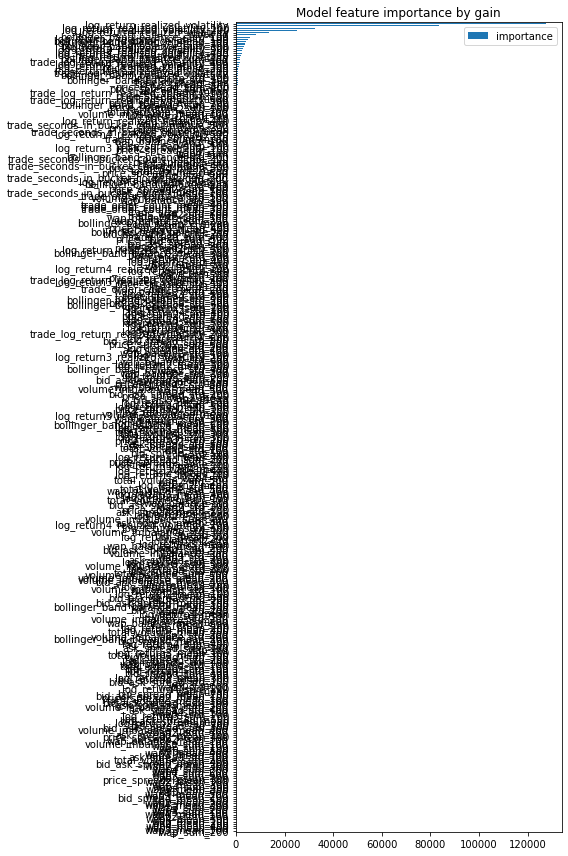

In [31]:
if DO_FEAT_IMP:
    mean_gain_df = calc_mean_importance(gain_importance_list)  
    plot_importance(mean_gain_df, title='Model feature importance by gain')
    mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_gain_df.to_csv('gain_importance_mean.csv', index=False)


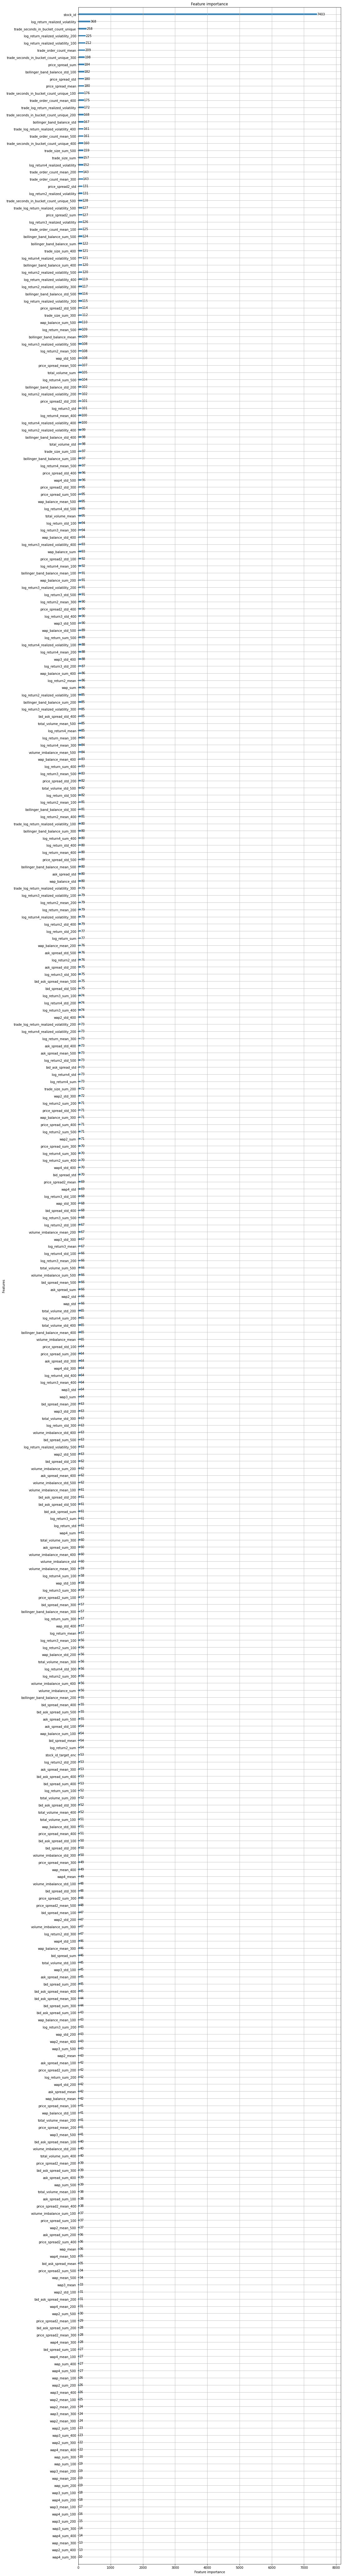

In [42]:
fig,ax = plt.subplots(figsize=(15,150))
lgbm.plot_importance(model,ax=ax)
plt.show()

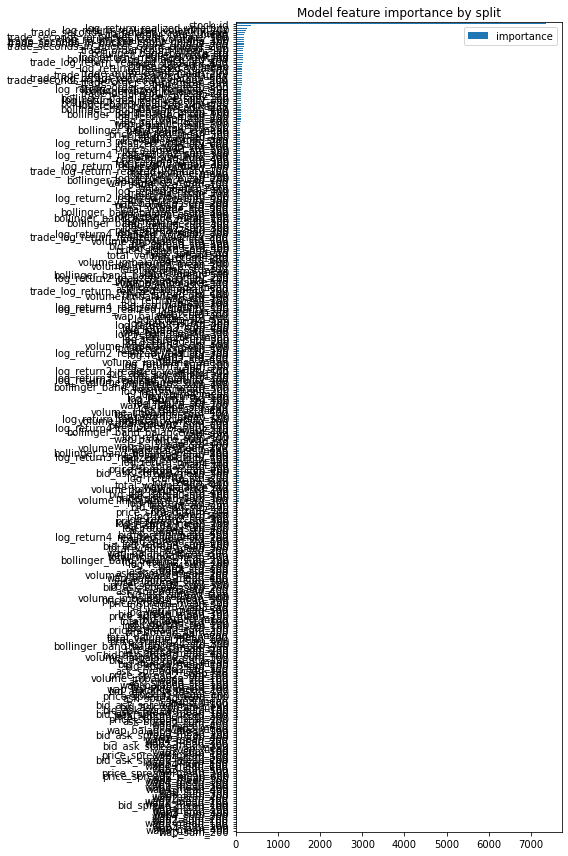

In [27]:
if DO_FEAT_IMP:
    mean_split_df = calc_mean_importance(split_importance_list)
    plot_importance(mean_split_df, title='Model feature importance by split')
    mean_split_df = mean_split_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_split_df.to_csv('split_importance_mean.csv', index=False)

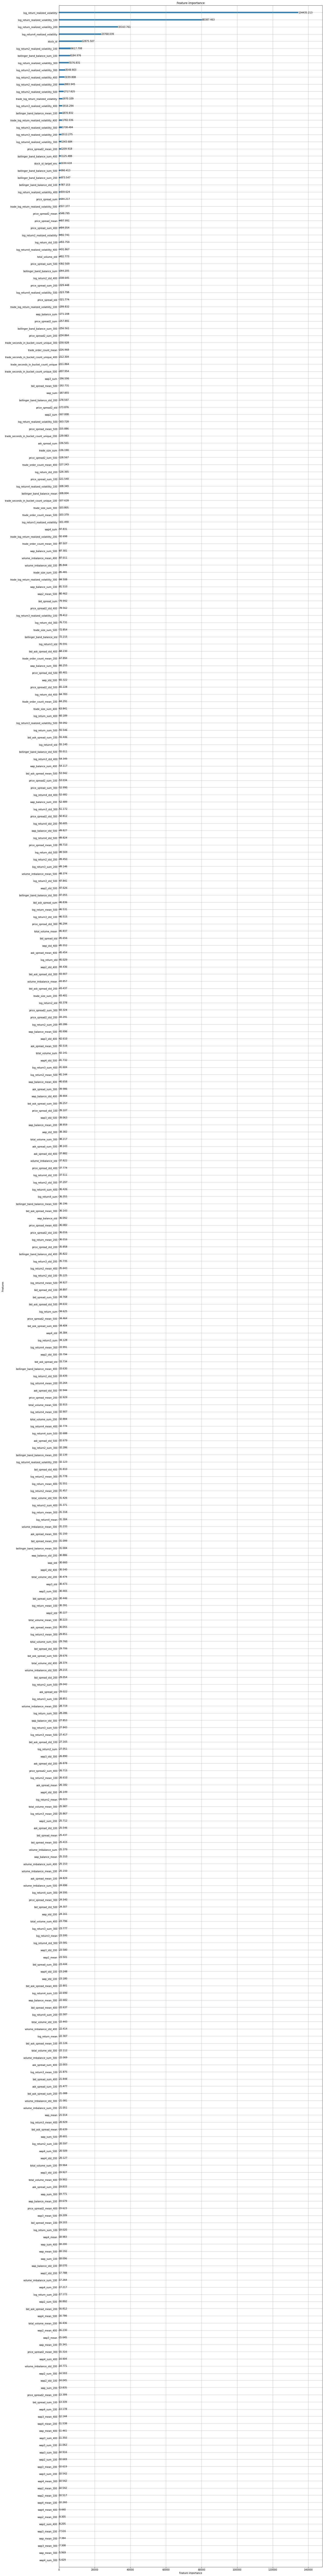

In [41]:
fig,ax = plt.subplots(figsize=(20,200))
lgbm.plot_importance(model,ax=ax,importance_type="gain")
plt.show()